In [1]:
# Spacy for lemmatization

import spacy
import nltk
import re
import pandas as pd
import numpy as np
from pprint import pprint
# Gensim
import gensim
from gensim import corpora
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models import LdaModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import nltk # nltk.download('stopwords') #run once
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\you\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
df = pd.read_json('en--2018-01-01---2018-12-31-preprocessed.jsonl', lines=True)
df.head()

,content,date,entities,entities_title,id,source_id,title,tokens,tokens_title
0,* Anger over corruption and hardship fuels pro...,2018-01-01 10:49:44,[],[country:ir],4634b7327a90b52a0656fd9abb4033d13ceb0eb5,9,UPDATE 2-Ten people killed in Iran unrest on S...,"[anger, corruption, hardship, fuel, protest, -...","[update, people, kill, iran, unrest, sunday, -..."
1,Bureau of Economic Analysis Table 1.3.1. Perce...,2018-01-01 05:00:00,[],[],05251a5c4bd1674f4cb4f0c7b6521943c5582c1d,589,Percent Change From Preceding Period in Real G...,"[bureau, economic, analysis, table, percent, c...","[percent, change, from, preceding, period, rea..."
2,"High-profile companies like Wells Fargo, Uber,...",2018-01-01 05:00:00,"[company:equifax, company:uber, company:wells_...",[],32125497a5bc12d06b8b91ad642bfcf8de504c0b,589,A Board's Duty: Ensure a Healthy Culture: Unde...,"[high, profile, company, like, wells, fargo, u...","[board, have, duty, ensure, healthy, culture, ..."
3,President Donald Trump slammed Pakistan for 'l...,2018-01-01 14:24:01,"[person:donald_trump, country:us, country:pk, ...","[person:donald_trump, country:us, country:pk]",34f120bf70ae226b18428eae5b071b7e06071816,51,Trump slams Pakistan for 'lies & deceit' in Ne...,"[president, donald, trump, slam, pakistan, lie...","[trump, slam, pakistan, lie, deceit, new, year..."
4,"Scope.\nApproved March 28, 2013. 160 pages. A ...",2018-01-01 05:00:00,"[topic:_robotics, topic:_safety_regulations, c...","[topic:_robotics, topic:_safety_regulations]",b4466ccf5f262f9fad2c55c34b97bd68d6050b7e,589,ANSI/RIA standard R15.06-2012 on safety requir...,"[scope, approved, march, page, revision, ansi,...","[ansi, ria, standard, safety, requirement, ind..."


In [3]:
#exploration of the data
#check for NaN or zero values this is the same for pandas dataframes.

print(df.isnull().head(5))

   content   date  entities  entities_title     id  source_id  title  tokens  \
0    False  False     False           False  False      False  False   False   
1    False  False     False           False  False      False  False   False   
2    False  False     False           False  False      False  False   False   
3    False  False     False           False  False      False  False   False   
4    False  False     False           False  False      False  False   False   

   tokens_title  
0         False  
1         False  
2         False  
3         False  
4         False  


In [4]:
df1 = df['tokens']

In [5]:
type(df1)

pandas.core.series.Series

In [6]:
pretokens = list(df1)

In [7]:
#this is the number of documents
len(pretokens)

362871

In [8]:
pretokens[1]

['bureau',
 'economic',
 'analysis',
 'table',
 'percent',
 'change',
 'from',
 'preceding',
 'period',
 'real',
 'gross',
 'value',
 'added',
 'sector',
 'percent',
 'seasonally',
 'adjust',
 'annual',
 'rate',
 'last',
 'revised',
 'january',
 'next',
 'release',
 'date',
 'february',
 'line',
 'gross',
 'domestic',
 'product',
 'business',
 'nonfarm',
 'farm',
 'households',
 'institution',
 'households',
 'nonprofit',
 'institution',
 'serve',
 'household',
 'general',
 'government',
 'federal',
 'state',
 'local',
 'addendum',
 'gross',
 'house',
 'value',
 'add',
 'line',
 'gross',
 'domestic',
 'product',
 'business',
 'nonfarm',
 'farm',
 'households',
 'institution',
 'households',
 'nonprofit',
 'institution',
 'serve',
 'household',
 'general',
 'government',
 'federal',
 'state',
 'local',
 'addendum',
 'gross',
 'house',
 'value',
 'add',
 'line',
 'gross',
 'domestic',
 'product',
 'business',
 'nonfarm',
 'farm',
 'households',
 'institution',
 'households',
 'nonprofit'

In [13]:
#prepare the stop_words from NLTK
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from','subject', 're', 'edu', 'use']) 

In [14]:
#define the functions for stop words
#it is important the function to return a list of list.Otherwise we losing information
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words and len(word) > 3] for doc in texts]
    
# Remove Stop Words
data_words_nostops = remove_stopwords(pretokens)




In [18]:
#save as a list directly
import pickle
with open('data_words_nostops2','wb') as f:
    pickle.dump(data_words_nostops1,f)

In [9]:
#load a list
import pickle
with open('data_words_nostops2','rb') as f:
    data_words_nostops=pickle.load(f)

In [15]:
# cleaning of the token words 

# matches all hyphens (minus) characters
pattern = '-' 
# empty string
replace = ' '
data_words_nostops = [[re.sub(pattern, replace, word) for word in doc] for doc in data_words_nostops] 

# clean the white spaces
pattern = '\s+' 
# empty string
replace = ''
data_words_nostops = [[re.sub(pattern, replace, word) for word in doc] for doc in data_words_nostops] 

# get rid of empty words
pattern = '' 
data_words_nostops = [[word for word in doc if word != pattern] for doc in data_words_nostops] 

In [16]:
#save as a list directly
#import pickle
#with open('data_words_nostops1','wb') as f:
#    pickle.dump(data_words_nostops,f)

In [ ]:
#load a list
import pickle
with open('data_words_nostops1','rb') as f:
    data_words_nostops=pickle.load(f)

In [17]:
data_words_nostops[0]

['anger', 'corruption', 'hardship', 'fuel', 'protest', 'demonstrators']

In [14]:
# build bigram & trigram models
#threshold : the higher the fewer phrases.
#min_count :ignore phrases with occurence less than the defined number 
bigram_phrases = Phrases(data_words_nostops, min_count=5, threshold = 100)
bigram_model = Phraser(bigram_phrases)
trigram_phrases = Phrases(bigram_phrases[data_words_nostops],threshold = 100)
trigram_model = Phraser(trigram_phrases)

C:\Users\you\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [15]:
#save bigram_model
bigram_model.save('bigram_model')

In [28]:
#load bigram_model
bigram_model=Phraser.load('bigram_model')

In [ ]:
#for faster implementation, but even then we have to train first the model to get the bigram_phrases??right??
#bigram_model=gensim.models.phrases.Phraser 

In [ ]:
print(trigram_model[bigram_model[data_words_nostops[8]]])

In [31]:
#get the bigram data in a list of list
bigram_data = []
for doc in data_words_nostops:
    bigram_data.append(bigram_model[doc])
    

In [32]:
len(bigram_data)

362871

In [33]:
#first lemmatization with spacy library
def lemmatization(bigram_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    words_out = []
    for sublist in bigram_data:
        doc = nlp(" ".join(sublist)) 
        words_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return words_out

In [34]:
import spacy
#disable parser,ner for computation time
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

In [36]:
data_lemmatized = lemmatization(bigram_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [37]:
#save list data_lemmatized
#import pickle
#with open('data_lemmatized1','wb') as f:
#    pickle.dump(data_lemmatized,f)

In [7]:
#load data_lemmatized
import pickle
with open('data_lemmatized1','rb') as f:
    data_lemmatized=pickle.load(f)

In [27]:
#In our case is not useful to apply stemming,since will reduce the readability of the output. 
#But in case we have data that is needed
# Secondly, stemming with nltk library 
#stemmer = SnowballStemmer("english")
#stem_data = [[stemmer.stem(word) for word in doc]for doc in data_lemmatized]
#or
#for doc in data_lemmatized:
#    for word in doc:
#        stem_data.append(stemmer.stem(word))


In [35]:
#stem_data[8]

['hillary_clinton',
 'rich',
 'friend',
 'unsuccess',
 'effort',
 'fund',
 'woman',
 'accus',
 'presid',
 'trump',
 'sexual_misconduct',
 'elect',
 'report',
 'sunday']

In [8]:
stem_data=data_lemmatized

In [63]:
#Create a dictionary for our data(dictionary over all the words of our data)
dictionary = gensim.corpora.Dictionary(stem_data)

In [64]:
#save dictionary to disk
#dictionary.save('dictionary_all_data')

In [4]:
# Load dictionary back
dictionary = corpora.Dictionary.load('dictionary_all_data')

In [65]:
#corpus=Document term frequency(the dictionary splited over each document of the data)
corpus = [dictionary.doc2bow(doc) for doc in stem_data]

In [66]:
#save corpus to disk
#corpora.MmCorpus.serialize('corpus.mm',corpus)

In [5]:
#load back corpus
corpus = corpora.MmCorpus('corpus.mm')


In [29]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=1,
                                           alpha='auto',
                                           per_word_topics=True)

In [33]:
lda_model=LdaModel.load('20 topics-alldata')

In [28]:
#top 10 of most important key words for each model-10 topics
pprint(lda_model.print_topics())

[(0,
  '0.014*"service" + 0.010*"business" + 0.010*"technology" + 0.010*"company" + '
  '0.009*"industry" + 0.009*"information" + 0.008*"include" + 0.008*"india" + '
  '0.008*"provide" + 0.008*"datum"'),
 (1,
  '0.035*"december" + 0.028*"news" + 0.017*"tender" + 0.015*"research" + '
  '0.014*"file" + 0.012*"open" + 0.011*"thursday" + 0.011*"report" + '
  '0.011*"friday" + 0.009*"november"'),
 (2,
  '0.090*"share" + 0.085*"company" + 0.023*"hold" + 0.019*"value" + '
  '0.019*"sell" + 0.019*"group" + 0.017*"price" + 0.016*"inc" + '
  '0.016*"financial" + 0.015*"management"'),
 (3,
  '0.019*"water" + 0.015*"power" + 0.015*"vehicle" + 0.012*"road" + '
  '0.011*"energy" + 0.011*"area" + 0.011*"construction" + 0.010*"plant" + '
  '0.009*"supply" + 0.009*"application"'),
 (4,
  '0.023*"health" + 0.013*"study" + 0.013*"medical" + 0.012*"care" + '
  '0.012*"hospital" + 0.010*"drug" + 0.010*"patient" + 0.009*"report" + '
  '0.009*"research" + 0.008*"treatment"'),
 (5,
  '0.013*"year" + 0.010*"pe

In [7]:
#top 10 of most important key words for each model-20 topics
pprint(lda_model.print_topics())

[(0,
  '0.022*"service" + 0.019*"system" + 0.018*"information" + 0.018*"technology" '
  '+ 0.016*"datum" + 0.012*"provide" + 0.010*"include" + 0.010*"website" + '
  '0.010*"network" + 0.010*"application"'),
 (1,
  '0.012*"photo" + 0.007*"video" + 0.006*"world" + 0.006*"start" + '
  '0.006*"away" + 0.006*"play" + 0.005*"show" + 0.005*"appear" + 0.005*"image" '
  '+ 0.005*"game"'),
 (2,
  '0.079*"contract" + 0.028*"supply" + 0.026*"article_content" + '
  '0.026*"requirement_contact" + 0.018*"australia" + 0.017*"profit" + '
  '0.017*"volume" + 0.015*"value" + 0.015*"hong_kong" + 0.011*"fuel"'),
 (3,
  '0.078*"wall" + 0.023*"gold" + 0.021*"material" + 0.013*"temperature" + '
  '0.012*"heat" + 0.012*"producer" + 0.010*"metal" + 0.009*"maximum" + '
  '0.009*"powell" + 0.008*"inch"'),
 (4,
  '0.016*"case" + 0.016*"issue" + 0.014*"agency" + 0.014*"federal" + '
  '0.013*"department" + 0.013*"order" + 0.013*"public" + 0.012*"information" + '
  '0.011*"state" + 0.011*"report"'),
 (5,
  '0.023*"pe

In [12]:
lda_model=LdaModel.load('30 topics-alldata')

In [6]:
#load it back
lda_model = LdaModel.load('20 topics-alldata')

In [10]:
#distribution of each document over the topics
doc_lda = lda_model[corpus] 

In [8]:
corpus[0] # sub-dictionary of document[0] 

[(0, 1.0), (1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0)]

In [11]:
doc_lda[0] #topic 5 is the dominant topic here

([(2, 0.013840961),
  (5, 0.6519797),
  (6, 0.017085537),
  (10, 0.053305928),
  (11, 0.083815515),
  (12, 0.012308595),
  (15, 0.035469566),
  (17, 0.042016625),
  (18, 0.04116221)],
 [(0, [5]), (1, [5]), (2, [5]), (3, [5]), (4, [5]), (5, [5])],
 [(0, [(5, 0.99999994)]),
  (1, [(5, 0.9999999)]),
  (2, [(5, 1.0000001)]),
  (3, [(5, 1.0)]),
  (4, [(5, 1.0)]),
  (5, [(5, 1.0)])])

In [12]:
#doc_lda[0] is the distribution of doc 0 over the topics
#checking if the dominant topic(5) is related with the content of document[0].
#topic 5 is about people,pron(pronominal?),work,time.. so there is relation.Our model performed good here.
print(df['content'][0])

* Anger over corruption and hardship fuels protests -demonstrators.


In [32]:
# Compute Coherence Score#all data/ 7 topics
coherence_model_lda = CoherenceModel(model=lda_model, texts=stem_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.48382692152385093


In [19]:
# Compute Coherence Score#all data/ 10 topics
coherence_model_lda = CoherenceModel(model=lda_model, texts=stem_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5026607208236324


In [10]:
# Compute Coherence Score#all data/ 20 topics
coherence_model_lda = CoherenceModel(model=lda_model, texts=stem_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.49533589665232824


In [16]:
# Compute Coherence Score#all data/ 30 topics
coherence_model_lda = CoherenceModel(model=lda_model, texts=stem_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  nan


In [11]:
# Compute Coherence Score#all data/ 40 topics
coherence_model_lda = CoherenceModel(model=lda_model, texts=stem_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.42864831058404873


In [20]:
# Visualize the 10-topics
pyLDAvis.enable_notebook()
plot = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
#pyLDAvis.sow(plot)
pyLDAvis.display(plot)

C:\Users\you\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [67]:
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.244469 -0.025796       1        1  22.979330
6     -0.164397 -0.037875       2        1  15.038999
0     -0.030522 -0.010526       3        1  13.517228
9     -0.205275  0.026844       4        1  13.313253
1     -0.032414  0.017181       5        1   9.567838
8      0.040062 -0.261424       6        1   7.604280
4      0.021672  0.159156       7        1   5.489874
2      0.261304 -0.240407       8        1   4.912991
7      0.201872  0.127192       9        1   3.894013
3      0.152166  0.245655      10        1   3.682196, topic_info=      Category           Freq           Term          Total  loglift  logprob
92     Default  321775.000000        company  321775.000000  30.0000  30.0000
256    Default  264646.000000          share  264646.000000  29.0000  29.0000
878    Default  177183.000000          trade  177183.000000  28.0000  28.0000
877    Default  175352.000000          stock  175352.000000  27.0000  27.0000
1079   Default  231024.000000       december  231024.000000  26.0000  26.0000
297    Default  386686.000000           year  386686.000000  25.0000  25.0000
51     Default  141283.000000           rate  141283.000000  24.0000  24.0000
200    Default  177601.000000           news  177601.000000  23.0000  23.0000
914    Default  164033.000000         market  164033.000000  22.0000  22.0000
899    Default  108216.000000        quarter  108216.000000  21.0000  21.0000
586    Default  132089.000000          trump  132089.000000  20.0000  20.0000
294    Default  147912.000000      president  147912.000000  19.0000  19.0000
17     Default   91854.000000           date   91854.000000  18.0000  18.0000
240    Default  192213.000000         report  192213.000000  17.0000  17.0000
518    Default  117255.000000          price  117255.000000  16.0000  16.0000
386    Default  137472.000000    information  137472.000000  15.0000  15.0000
156    Default  113873.000000           hold  113873.000000  14.0000  14.0000
811    Default  143562.000000        country  143562.000000  13.0000  13.0000
28     Default  179097.000000     government  179097.000000  12.0000  12.0000
254    Default  194962.000000        service  194962.000000  11.0000  11.0000
14882  Default   94398.000000         tender   94398.000000  10.0000  10.0000
152    Default   74395.000000         health   74395.000000   9.0000   9.0000
364    Default  116744.000000          group  116744.000000   8.0000   8.0000
244    Default  121431.000000       research  121431.000000   7.0000   7.0000
1642   Default   61958.000000         notice   61958.000000   6.0000   6.0000
3347   Default   77923.000000         dollar   77923.000000   5.0000   5.0000
2329   Default   58953.000000       contract   58953.000000   4.0000   4.0000
344    Default   61949.000000       document   61949.000000   3.0000   3.0000
46     Default   90739.000000        percent   90739.000000   2.0000   2.0000
62     Default   82441.000000          value   82441.000000   1.0000   1.0000
...        ...            ...            ...            ...      ...      ...
8928   Topic10    5594.486816         reopen    5595.314941   3.3015  -5.9579
514    Topic10    5395.884277          motor    5396.711914   3.3015  -5.9941
8374   Topic10    5284.165527          tokyo    5284.993164   3.3015  -6.0150
4518   Topic10    5189.357422           seal    5190.185059   3.3015  -6.0331
2645   Topic10    5105.531250          plate    5106.358887   3.3015  -6.0494
498    Topic10   13538.079102           zone   13569.361328   3.2994  -5.0742
724    Topic10   22301.855469          plant   22550.896484   3.2906  -4.5750
787    Topic10   40299.453125          water   41020.554688   3.2839  -3.9834
1648   Topic10    7894.783691         repair    8052.319336   3.2819  -5.6135
623    Topic10   16574.525391     contractor   17768.708984   3.2321  -4.8719
11570  Topic10   15855.594727    

In [21]:
#save the interactive plot
pyLDAvis.save_html(plot, 'lda.html_10_topics')

In [ ]:
#load the pyLDAvis
pyLDAvis.enable_notebook(local=False)

In [ ]:
#lda_model[coprus] needs 4 indexes to be expressed in case the lda_model.per_word_topics argument is True.
#checking if this parameter is True
#lda_model.per_word_topics

In [106]:
import time

start=time.time()

def format_topics_sentences(ldamodel=lda_model, corpus=corpus,texts=df['content']):
    # Init output
    doc_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(lda_model[corpus][200000:300000]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    doc_topics_df = pd.concat([doc_topics_df, contents], axis=1)
    return(doc_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['content'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

end=time.time()

print((end-start)/60) #in minutes

855.1503803849221


In [109]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.2703,"trump, country, president, india, china, borde...",* Anger over corruption and hardship fuels pro...
1,1,12.0,0.2539,"tender, date, file, notice, document, court, d...",Bureau of Economic Analysis Table 1.3.1. Perce...
2,2,0.0,0.3258,"service, system, information, technology, datu...","High-profile companies like Wells Fargo, Uber,..."
3,3,5.0,0.0917,"people, pron, time, tell, year, want, come, kn...",President Donald Trump slammed Pakistan for 'l...
4,4,11.0,0.5151,"share, company, stock, trade, price, hold, sel...","Scope.\nApproved March 28, 2013. 160 pages. A ..."


In [ ]:
#save- 748,673 minutes execution time
#df_dominant_topic.to_csv('df_dominant_topic.csv300000_362871') 

In [107]:
#save-855,15 minutes execution time
#df_dominant_topic.to_csv('df_dominant_topic.csv200000_300000')

In [ ]:
#save-655,218 minutes execution time
#df_dominant_topic.to_csv('df_dominant_topic.csv120000_200000') 

In [102]:
#save-678,689 minutes execution time
#df_dominant_topic.to_csv('df_dominant_topic.csv20000_120000')

In [ ]:
#save- minutes execution time
#df_dominant_topic.to_csv('df_dominant_topic.csv10000_20000') 

In [36]:
#SUM THE DATA-FRAMES
#load the sub-dataframes
df_part1=pd.read_csv('df_dominant_topic.csv_first_10000')
df_part2=pd.read_csv('df_dominant_topic.csv10000_20000')
df_part3=pd.read_csv('df_dominant_topic.csv20000_120000')
df_part4=pd.read_csv('df_dominant_topic.csv120000_200000')
df_part5=pd.read_csv('df_dominant_topic.csv200000_300000')
df_part6=pd.read_csv('df_dominant_topic.csv300000_362871')

C:\Users\you\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
#drop the text column,since we can not concatenate the sud-dataframes we produced to get the dominant_topic,etc
#and add it again later in order to avoid to run the big loop again.(i forgot to ignore the text from the big loop)
df_part1=df_part1.drop('Text',axis=1)
df_part2=df_part2.drop('Text',axis=1)
df_part3=df_part3.drop('Text',axis=1)
df_part4=df_part4.drop('Text',axis=1)
df_part5=df_part5.drop('Text',axis=1)
df_part6=df_part6.drop('Text',axis=1)

In [38]:
#concatenate the sub-dataframes
frame=[df_part1[:10000],df_part2[:10000],df_part3[:100000],df_part4[:80000],df_part5[:100000],df_part6[:62871]]
data_concatenate=pd.concat(frame)
data_concatenate=data_concatenate.reset_index(drop=True)#becareful here, you have to name again(store it),df=df.reset..
data_concatenate['doc_num']=data_concatenate.index#create a column 
data_concatenate=data_concatenate[['doc_num','Dominant_Topic','Topic_Perc_Contrib','Keywords']]#re-order columns


In [39]:
#add the original texts
data_concatenate['text']=df['content']

In [40]:
df_dominant_topic_all=data_concatenate

In [ ]:
#save
#df_dominant_topic_all.to_csv('df_dominant_topic_all')

In [ ]:
#load the df_dominant_topic_all dataframe (20 topics)
df_dominant_topic_all= pd.read_csv('df_dominant_topic_all')

In [41]:
#keep only the date from the datetime variable 'date'
from datetime import date
df_dominant_topic_all['just_date'] = df['date'].dt.date

In [42]:
df_dominant_topic_all.head()

,doc_num,Dominant_Topic,Topic_Perc_Contrib,Keywords,text,just_date
0,0,5.0,0.1671,"people, pron, time, tell, year, want, come, kn...",* Anger over corruption and hardship fuels pro...,2018-01-01
1,1,6.0,0.2462,"year, percent, high, monday, month, increase, ...",Bureau of Economic Analysis Table 1.3.1. Perce...,2018-01-01
2,2,17.0,0.2500,"company, business, project, market, developmen...","High-profile companies like Wells Fargo, Uber,...",2018-01-01
3,3,8.0,0.1588,"trump, country, president, india, china, borde...",President Donald Trump slammed Pakistan for 'l...,2018-01-01
4,4,4.0,0.3455,"case, issue, agency, federal, department, orde...","Scope.\nApproved March 28, 2013. 160 pages. A ...",2018-01-01


In [28]:
#find the count of the words for each doc 
doc_len=[]
for d in range(len(df['tokens'])):
    a=len(df['tokens'][d])
    doc_len.append(a)

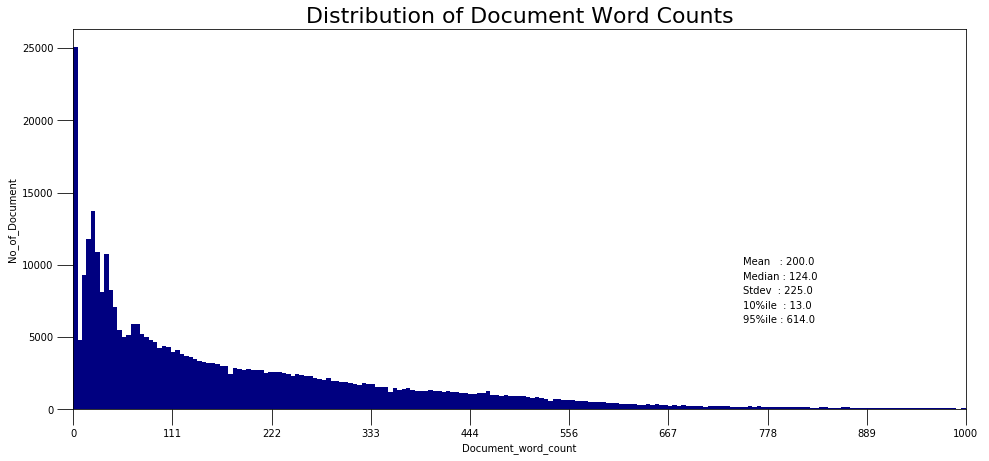

In [29]:
# Plot histogram
plt.figure(figsize=(16,7))
plt.hist(doc_len,bins=500, color='navy')
plt.text(750, 10000, "Mean   : " + str(round(np.mean(doc_len))))
plt.text(750,  9000, "Median : " + str(round(np.median(doc_len))))
plt.text(750,  8000, "Stdev  : " + str(round(np.std(doc_len))))
plt.text(750,  7000, "10%ile  : " + str(round(np.quantile(doc_len, q=0.10))))
plt.text(750,  6000, "95%ile : " + str(round(np.quantile(doc_len, q=0.95))))

plt.gca().set(xlim=(0, 1000), ylabel='No_of_Document', xlabel='Document_word_count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,10))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [43]:
#distribution of each topic over the body of documents
doc_per_topic = df_dominant_topic_all['Dominant_Topic'].value_counts().reset_index()

In [72]:
#rename the columns
doc_per_topic.columns=['dominant_topic','num_doc']

In [73]:
topic_contribution_perc=round(doc_per_topic['num_doc']/doc_per_topic['num_doc'].sum(),3)

In [74]:
topic_doc_distribution=pd.concat([doc_per_topic,topic_contribution_perc],axis=1)

In [75]:
topic_doc_distribution.columns=['dominant_topic','num_doc','perc_doc']

In [69]:
topic_doc_distribution.head(10)

,dominant_topic,num_doc,perc_doc
0,5.0,73481,0.202
1,6.0,34671,0.096
2,0.0,31816,0.088
3,17.0,30059,0.083
4,8.0,29460,0.081
5,4.0,22365,0.062
6,12.0,21132,0.058
7,19.0,19711,0.054
8,11.0,16030,0.044
9,7.0,15498,0.043


<Figure size 1872x720 with 0 Axes>

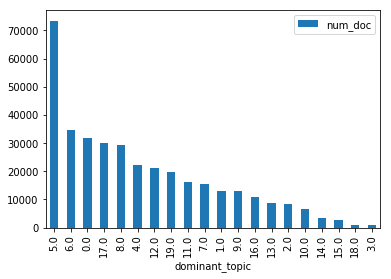

In [51]:
plt.figure(figsize=(26,10)) 
topic_doc_distribution.plot.bar(x='dominant_topic',y='num_doc')
plt.show()

In [71]:
#per day,per topic, amount of documents 
#setting as_index=false the group_by attributes are not used as indexes
per_day_results=df_dominant_topic_all.groupby([ 'Dominant_Topic', 'just_date'],as_index=False)['doc_num'].count()


In [76]:
per_day_results['sum_of_doc']=per_day_results['doc_num']

In [77]:
per_day_results=per_day_results.drop('doc_num',axis=1)

In [78]:
per_day_results.head(10)

,Dominant_Topic,just_date,sum_of_doc
0,0.0,2018-01-01,112
1,0.0,2018-01-02,45
2,0.0,2018-01-03,55
3,0.0,2018-01-04,76
4,0.0,2018-01-05,71
5,0.0,2018-01-06,24
6,0.0,2018-01-07,8
7,0.0,2018-01-08,82
8,0.0,2018-01-09,113
9,0.0,2018-01-10,80


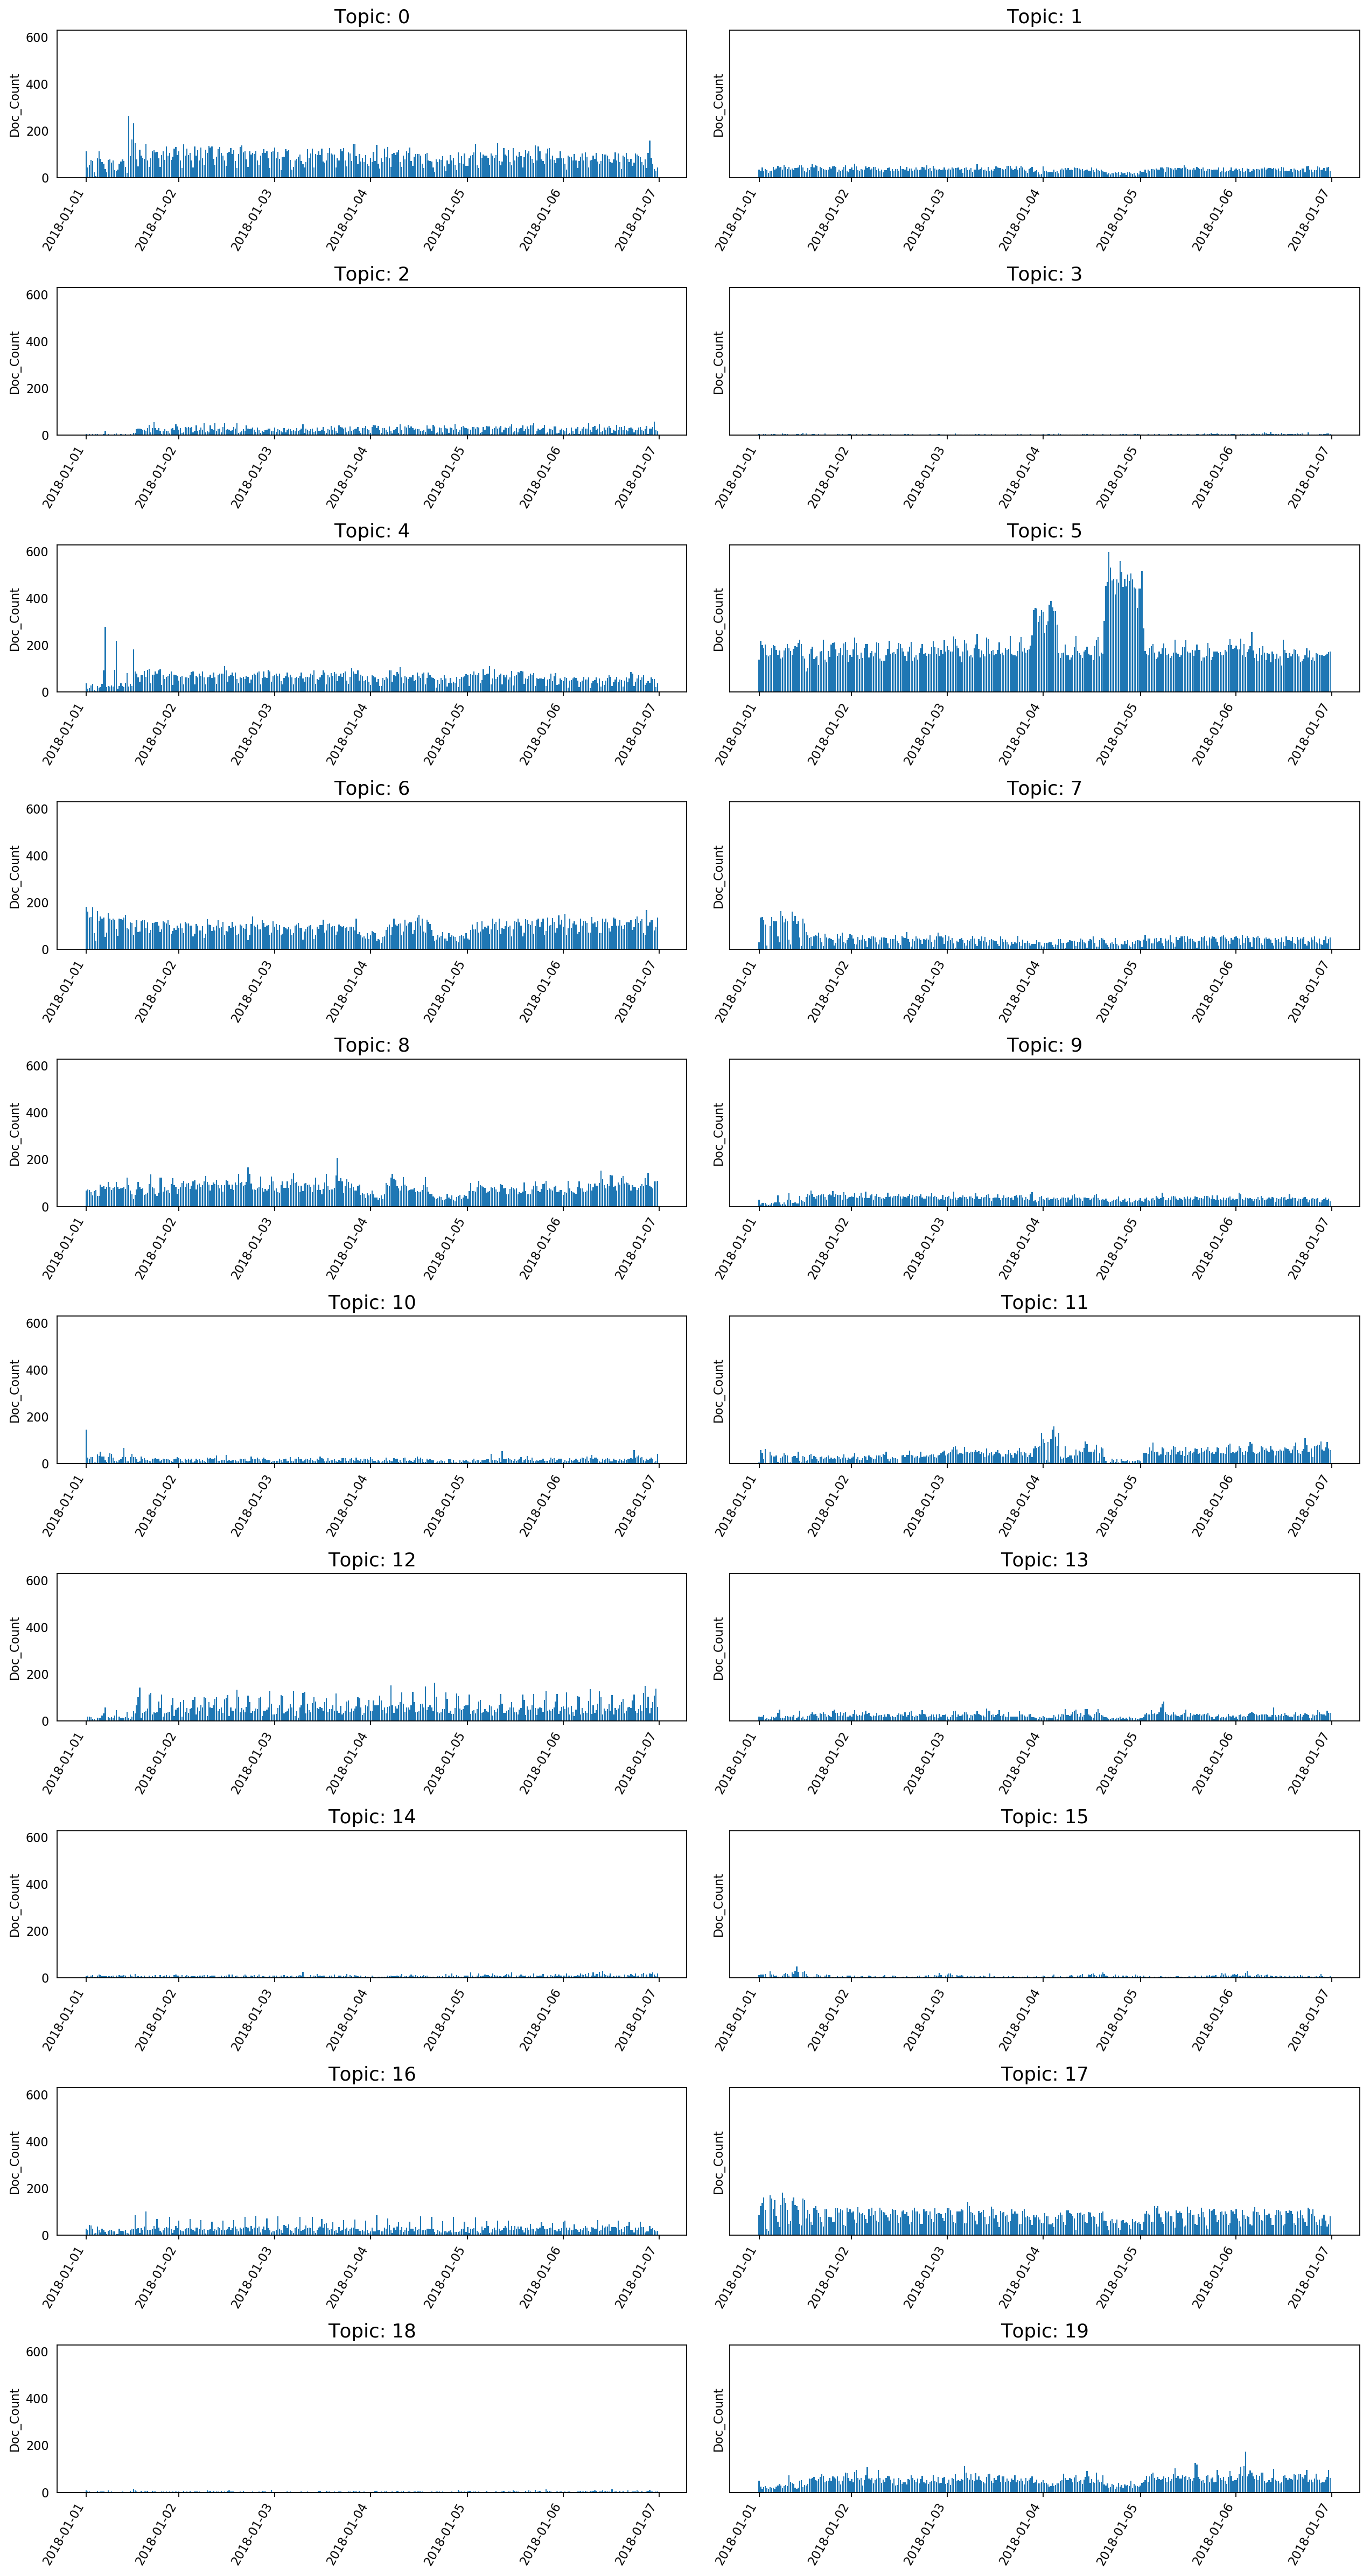

In [79]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

fig, axes = plt.subplots(10, 2, figsize=(16,30), sharey=True, dpi=160)

for i, ax in enumerate(axes.flat):
    ax.bar(x='just_date', height="sum_of_doc", data=per_day_results.loc[per_day_results.Dominant_Topic==i, :])
    ax.set_ylabel('Doc_Count')
    ax.set_title('Topic: ' + str(i), fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(per_day_results['just_date'], rotation=60, horizontalalignment= 'right')
    fig.tight_layout(w_pad=2)
    #fig.suptitle('Doc Count per Topic/per day', fontsize=22, y=1.00)    
plt.show()

In [55]:
#replace nan with zero values
df_dominant_topic_all['Topic_Perc_Contrib']=df_dominant_topic_all['Topic_Perc_Contrib'].replace('nan',np.nan).fillna(0)

In [56]:
#find the most representative docs for each dominant topic
most_repre_doc=[]
for i in df_dominant_topic_all['Dominant_Topic']:
    repre_doc=df_dominant_topic_all[df_dominant_topic_all.Dominant_Topic==i]
    if len(repre_doc['Topic_Perc_Contrib'])!=0:
        repre_doc1=repre_doc.loc[repre_doc['Topic_Perc_Contrib'].idxmax(),:]
        most_repre_doc.append(repre_doc1)

In [57]:
#save 
#import pickle
#with open('most_repre_doc','wb') as f:
#    pickle.dump(most_repre_doc,f)

In [ ]:
#load 
import pickle
with open('most_repre_doc','rb') as f:
    most_repre_doc=pickle.load(f)

In [59]:
#try for the range of number that dominant topics are.20.
#here we are getting the 20 most representative doc for each topic
most_repre_doc20=[]
for i in range(20):
    repre_doc=df_dominant_topic_all[df_dominant_topic_all.Dominant_Topic==i]
    if len(repre_doc['Topic_Perc_Contrib'])!=0:
        repre_doc1=repre_doc.loc[repre_doc['Topic_Perc_Contrib'].idxmax(),:] 
        most_repre_doc20.append(repre_doc1)

In [60]:
most_repre_doc20

[doc_num                                                          209239
 Dominant_Topic                                                        0
 Topic_Perc_Contrib                                               0.7387
 Keywords              service, system, information, technology, datu...
 text                  Alexandria, July 31 -- NEC Corporation has sec...
 just_date                                                    2018-07-31
 Name: 209239, dtype: object,
 doc_num                                                          174703
 Dominant_Topic                                                        1
 Topic_Perc_Contrib                                               0.5692
 Keywords              photo, video, world, start, away, play, show, ...
 text                  * window._taboola = window._taboola || []; _ta...
 just_date                                                    2018-06-26
 Name: 174703, dtype: object,
 doc_num                                                        

In [66]:
#topic 0 --> label:Patent
df['content'][209239]

'Alexandria, July 31 -- NEC Corporation has secured a patent on path control system, control device and path control method. Kizu Yoshiya and Kashima Kenichi developed the invention. The patent application number is 14/380,693. The International Patent Classification codes are G06F 9/00 (20060101), H04L 12/803 (20130101), H04L 12/715 (20130101), H04L 29/08 (20060101), H04L 29/06 (20060101) and H04L 12/729 (20130101). Cooperative Patent Classification codes are H04L 63/0227 (20130101), H04L 45/64 (20130101), H04L 47/122 (20130101), H04L 67/322 (20130101), H04L 69/14 (20130101), H04L 63/0209 (20130101), H04L 63/164 (20130101) and H04L 45/125 (20130101).\nThe abstract released by U.S. Patent and Trademark Office states, "To provide a path control system, a control device and a path control method that can achieve reduction of the load on a gateway device, there are included a communication device, a communication device, a security device that provides a security feature to data transmitt

In [62]:
#topic 2 --> label: Railway investments
df['content'][325465]

'Slovakia, Nov. 23 -- Contract Id: 1350536.\nDescription: Slovakia based Zeleznicne opravovne a strojarne Zvolen, a.s. has secured contract from Zeleznicna spolocnost Slovensko, a.s. for Parts of railway or tramway locomotives or rolling stock.\nThe contract is valued approximately 100 000.00 EUR.\nCountry: Slovakia.\nSector: Industry.\nContract awarded to Zeleznicne opravovne a strojarne Zvolen, a.s. 31615783 Moovska cesta 259/11 Zvolen 960 03 Slovakia.\nContract awarded to executing agency: Zeleznicna spolocnost Slovensko, a.s. 35914939 Rozavska 1 Bratislava-mestska as Nove Mesto 832 72 Slovakia Contact person: Ing. Betikova Telephone: +421 220294495 E-mail: betikova.svetlana@slovakrail.sk <mailto:betikova.svetlana@slovakrail.sk> Published by HT Digital Content Services with permission from Pivotal Sources. For any query with respect to this article or any other content requirement, please contact Editor at contentservices@htlive.com <mailto:contentservices@htlive.com>.'

In [61]:
#topic 4 --> label:federal-case-issue
df['content'][72650]

'SUMMARY: In accordance with the Privacy Act of 1974, the Department of Homeland Security (DHS) proposes to modify and reissue a current DHS system of records titled, "DHS/ALL-014 Department of Homeland Security Personnel Contact Information." This system of records covers DHS\'s collection and maintenance of records concerning DHS personnel (including Federal employees and contractors) for workforce accountability; DHS and non-DHS Federal employees, contractors, or other individuals who participate in or respond to all-hazard emergencies, including technical, manmade, or natural disasters, or who participate in emergency response training exercises; and individuals identified as emergency points of contact. Categories of individuals, categories of records, and retention schedules for this system of records have been modified and expanded to better reflect the Department\'s emergency personnel location record systems. Additionally, this notice includes non-substantive changes to simpli

In [53]:
#topic 8 --> label:U.S. military forces
df['content'][252828]

"The source said that the government forces had taken up a position 12 kilometers (7 miles) east of Al Hodeidah and blocked the strategic Al Hodeidah-Sanaa highway after fighting against Houthi militants with the support of intensive [Saudi-led] coalition airstrikes.\nREAD MORE: Yemen President Hadi Headed to US for Urgent Medical Treatment — Reports.\nREUTERS / Khaled Abdullah Road to Peace in Yemen Begins Despite Houthis' Absence at Geneva Talks – UN Envoy On June 13, the Yemeni government forces, backed by the Saudi-led coalition, launched an offensive to seize the port of Hodeidah from the Shia Houthi rebels. The operation continued despite the UN warnings of a possible humanitarian catastrophe. UN Special Envoy Martin Griffiths held talks with the Houthis in the Yemeni capital of Sanaa, but failed to persuade the rebels to withdraw from al Hodeidah. Yemen has been engulfed in an armed conflict between the government forces led by President Abd Rabbuh Mansur Hadi and the Houthi reb

In [54]:
#topic 10--> label: stock market-dollar-banks
df['content'][418]

'Exchange rates, interest rates and prices 2013a 2014a 2015a 2016a 2017b 2018c 2019c Exchange rates Exchange rate KD:US$ (av) 0.284 0.284 0.301 0.302 0.304 0.298 0.297 Exchange rate KD:US$ (end-period) 0.282 0.293 0.303 0.306 0.302 0.298 0.294 Exchange rate ¥:KD (av) 344.0 372.1 402.2 359.9 368.5 365.9 359.5 Exchange rate ¥:KD (end-period) 373.2 409.3 396.3 381.6 368.2 363.0 359.6 Exchange rate KD:€ (av) 0.377 0.378 0.334 0.334 0.342 0.349 0.343 Exchange rate KD:€ (end-period) 0.389 0.355 0.330 0.323 0.355 0.347 0.344 Real effective exchange rate (consumer prices; 1997=100) 112.8b 114.9b 121.2b 122.7b 122.6 126.3 129.4 Interest rates Lending interest rate (av; %) 4.6 4.3 4.3 4.5 4.8 5.3 5.8 Deposit interest rate (av; %) 2.0 2.0 1.9 1.6 2.2 3.0 3.5 Money market interest rate (av; %) 0.6 1.0 1.1 1.5 2.0 2.5 3.0 Money market spread over US T-bills (basis points) 59 101 109 113 109 100 74 Real money market rate (av; %) 7.2 -1.8 -2.1 -1.5 0.2 -0.6 -0.4 Prices Consumer prices (av; % change) 

In [55]:
#topic 11--> label: shares,trade,private company
df['content'][33809]

'VOD Vodafone Group PLC value of shares traded £75,142,296 BP. BP PLC value of shares traded £51,175,813 GLEN Glencore PLC value of shares traded £48,940,991 HSBA HSBC Holdings PLC value of shares traded £48,851,899 RIO Rio Tinto PLC value of shares traded £45,090,712 RDSB Royal Dutch Shell value of shares traded £43,617,183 LLOY Lloyds Banking Group PLC ORD value of shares traded £43,004,958 RDSA Royal Dutch Shell value of shares traded £41,820,027 GSK GlaxoSmithKline PLC value of shares traded £40,865,239 BATS British American Tobacco PLC value of shares traded £39,814,131 BLT BHP Billiton PLC value of shares traded £39,615,164 AZN AstraZeneca PLC value of shares traded £38,890,368 TSCO Tesco PLC value of shares traded £37,825,161 AAL Anglo American PLC value of shares traded £34,042,346 PRU Prudential PLC value of shares traded £32,644,829 DGE Diageo PLC value of shares traded £30,902,083 BARC Barclays PLC value of shares traded £23,397,294 REL RELX Plc value of shares traded £23,03

In [56]:
#topic 17--> label: administration,company
df['content'][404]

"AES Corporation, a manufacturer of long-range wireless private mesh radio alarm communication products and services, named Patrick Moran as president and COO.\nMoran brings strong leadership experience to AES with extensive knowledge of strategic implementation, project management, employee engagement, change management, global initiatives and organizational diversity, AES described. Moran's appointment supports the company's vision, mission and business plans to advance corporate goals and objectives. He will be providing expertise in strategy, operations and finance.\nPrior to joining AES, Moran held high ranking positions and strategic advisory roles at investment banking, management consulting, renewable energy technology and non-profit companies."

In [58]:
#topic 19--> label: elections
df['content'][6279]

"Elections: The latest election for the Lok Sabha (the lower house of parliament) was held in April-May 2014. The National Democratic Alliance won a com-fortable majority, garnering 336 out of the 543 seats. The Bharatiya Janata Party (BJP), which dominates the ruling coalition, won an outright majority with 282 seats. The United Progressive Alliance, led by the Indian National Congress party, suffered a humiliating defeat-its tally in the general election fell to 59 seats. The next election is due to take place by May 2019.\nGovernment: The prime minister, Narendra Modi, is the head of the executive branch of government. He heads the Council of Ministers, who are chosen from elected members of the country's bicameral parliament. The president, who is indirectly elected for a five-year term by the national and state legislatures, is head of state. Ram Nath Kovind was elected president in July 2017.\nMajor political parties: BJP; Indian National Congress; All India Anna Dravida Munnetra